# **Installing Necessary Libraries**

In [ ]:
!pip install pytesseract
!pip install easyocr
!pip install mysql-connector-python
!sudo apt-get install tesseract-ocr
!pip install pytesseract

# **Importing Libraries**

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import requests
import pytesseract
import easyocr
import re
import mysql.connector
from mysql.connector import Error
from PIL import Image
from google.colab.patches import cv2_imshow
from collections import deque

# **Real-time Traffic Light Color Recognition**

*Region of Interest (ROI): This is where we expect our traffic light to be, and we isolate this portion from the rest to focus our analysis on it.*


In [4]:
def detect_traffic_light_color(image, rect):
  # Extracting rectangular dimensions
  x, y, w, h = rect
  # Extracting region of interest(ROI) from the image based on the rectangle
  roi = image[y:y+h, x:x+w]

  # Converting ROI to HSV color space (To separate color information from intensity)
  hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

  # Defining HSV range for red color
  red_lower = np.array([0, 120, 70])
  red_upper = np.array([10, 255, 255])

  # Defining HSV range for yellow color
  yellow_lower = np.array([20, 100, 100])
  yellow_upper = np.array([30, 255, 255])

  green_lower = np.array([40, 70, 70])
  green_upper = np.array([80, 255, 255])


  # Create binary masks for detecting red and yellow color by isolating the ROI from rest of the image.
  red_mask = cv2.inRange(hsv, red_lower, red_upper)
  yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
  green_mask = cv2.inRange(hsv, green_lower, green_upper)

  # Font details for overlaying text on the image.
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_thickness = 2

  color = None
  message = 'Detected Signal Status: Unknown'
  text_color = (255, 255, 255)  # Default text color in case none of the masks are found

  # Checking which color is present based on the masks
  if cv2.countNonZero(red_mask) > 0:
    text_color = (0, 0, 255)
    messege = "Detected Signal Status: Stop"
    color = "red"
  elif cv2.countNonZero(yellow_mask) > 0:
    text_color = (0, 255, 255)
    message = 'Detected Signal Status: Caution'
    color = 'yellow'
  elif cv2.countNonZero(green_mask) > 0:
    text_color = (0, 255, 0)
    message = 'Detected Signal Status: Go'
    color = 'green'
  # Overlay the detected traffic light status on the main image
  cv2.putText(image, message, (15, 70), font, font_scale+0.5, text_color, font_thickness+1, cv2.LINE_AA)

  # Adding a seperator line
  cv2.putText(image, 34*'-', (10, 115), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

  # Returning the modified image and detected color
  return image, color


# **Stop Line Detection**

In [5]:
class LineDetector:
  def __init__(self, num_frames_avg = 10):

    # Initialize two deque queues store y-coordinate values across frames
    self.y_start_queue = deque(maxlen = num_frames_avg)
    self.y_end_queue = deque(maxlen = num_frames_avg)


  def detect_white_line(self, frame, color, slope1 = 0.03, intercept1 = 920,
                          slope2 = 0.03, intercept2 = 770,
                          slope3 = -0.8, intercept3 = 2420):


      # Function for mapping color names to corresponding BGR values
      def get_color_code(color_name):
        color_code = {'red': (0, 0, 255),
                      'yellow': (0, 255, 255),
                      'green': (0, 255, 0)
                      }
        return color_code.get(color_name.lower(), (255, 255, 255)) # Default to white if not found

      frame_org = frame.copy()

      # Line equations for defining region of interest (ROI).

      def line1(x): return slope1 * x + intercept1

      def line2(x): return slope2 * x + intercept2

      def line3(x): return slope3 * x + intercept3

      height, width, _ = frame.shape

      # Creating a mask for ROI to isolate it from irrelevant regions
      mask1 = frame.copy()

      # Setting pixels below the first line to black in mask1.
      for x in range(width):
        y_line = line1(x)
        mask1[int(y_line):, x] = 0

      mask2 = mask1.copy()

      # Setting pixels above the second line to black in mask2.
      for x in range(width):
        y_line = line2(x)
        mask2[:int(y_line), x] = 0

      mask3 = mask2.copy()

      # Setting pixels to the left of the third line to black in mask 3(final mask)
      for x in range(width):
        y_line = line3(x)
        mask3[int(y_line):, x] = 0

      # Convert the mask to grayscale
      gray = cv2.cvtColor(mask3, cv2.COLOR_BGR2GRAY)

      # Apply Gaussian blur to reduce noise and smoothen the grayscale image.
      blurred_gray = cv2.GaussianBlur(gray, (7, 7), 0)

      # Applu CLAHE to equalize the histogram and to enhance the local contrast.
      clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
      gray_clahe = clahe.apply(blurred_gray) # Prepares the image for edge detection by improving clarity and reducing noise.

      # Performes edge detection.
      edges = cv2.Canny(gray, 30, 100)

      # Performs a dilation and erosion to close gaps in between object edges
      dilated_edges = cv2.dilate(edges, None, iterations = 1)
      edges = cv2.erode(dilated_edges, None, iterations = 1) # These steps ensures the line segments are continuous.

      # Performs Hough Line Transform to detect lines in the edge-detected image.
      lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength = 160, maxLineGap = 50)

      x_start = 0
      x_end = width - 1

      if lines is not None:
        for line in lines:
          x1, y1, x2, y2 = line[0]

          # Calculation slope and intercept of detected line
          slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps) # adding a small number for avoiding division with zero.
          intercept = y1 - slope * x1 #These values helps in computing the line’s position and ensure smooth tracking over multiple frames.

          # Calculating corresponding y coordinates
          y_start = int(slope * x_start + intercept)
          y_end = int(slope * x_end + intercept)

          # Adding y_start and y_end values to the queues
          self.y_start_queue.append(y_start)
          self.y_end_queue.append(y_end)

      # computing the average y_start and y_end values
      avg_y_start = int(sum(self.y_start_queue) / len(self.y_start_queue)) if self.y_start_queue else 0
      avg_y_end   = int(sum(self.y_end_queue) / len(self.y_end_queue)) if self.y_end_queue else 0

      # Drawing the line
      line_start_ratio = 0.32

      x_start_adj = x_start + int(line_start_ratio * (x_end - x_start)) # Adjusted x_start
      avg_y_start_adj = avg_y_start + int(line_start_ratio * (avg_y_end - avg_y_start))  # Adjusted avg_y_start_adj

      # Creating a mask with the same size as the frame and all zeros(black).
      mask = np.zeros_like(frame)

      # Drawing the line on the mask.
      cv2.line(mask, (x_start_adj, avg_y_start_adj), (x_end, avg_y_end), (255, 255, 255), 4)

      # Determining which color channel(s) to change based on the color argument.
      color_code = get_color_code(color)
      if color_code == (0, 255, 0):
        channel_indices = [1]
      elif color_code == (0, 0, 255):
        channel_indices = [2]
      elif color_code == (0, 255, 255):  # yellow in BGR is a combination of green and red channels.
        channel_indices = [1, 2]

      else:
        raise ValueError("Unsupported Color")

      # Changing the specified color channels of the frame where the mask is white.
      for channel_index in channel_indices:
        frame[mask[:,:,channel_index] == 255, channel_index] = 255 #Updates the specified color channel in the frame wherever the mask is white.

      # Calculate slope and intercept
      slope_avg = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
      intercept_avg = avg_y_start - slope_avg * x_start

      mask_line = np.copy(frame_org)

      # Creates a masked frame with pixels above the detected line set to black.
      for x in range(width):
        y_line = slope_avg * x + intercept_avg - 35

        mask_line[:int(y_line), x] = 0  # sets pixels above the line to black
        '''This mask serves as the second output of our method and plays a pivotal role in subsequent
          steps, particularly in isolating license plates of cars positioned below the line—effectively
          targeting vehicles that have crossed the stop line during a red light signal. '''
      return frame, mask_line


# **License Plate Extraction**

In [13]:
def extract_license_plate(frame, mask_line, license_plate_cascade):
    # Converting the image to grayscale
    gray = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)

    # Applying CLAHE to equalize the histogram
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Eroding the image to reduce noise
    kernel = np.ones((2, 2), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)

    # Finding the Bounding Box of Non-Black Pixels
    non_black_points = cv2.findNonZero(gray)
    if non_black_points is None:
        return frame, []  # Return if no non-black points are found

    x, y, w, h = cv2.boundingRect(non_black_points)

    # Adjusting the Bounding Box Width
    w = int(w * 0.7)  # Adjust width to exclude unwanted regions on the right

    # Crop the image
    cropped_gray = gray[y:y+h, x:x+w]

    # Detecting license plates in the image
    license_plates = license_plate_cascade.detectMultiScale(
        cropped_gray, scaleFactor=1.07, minNeighbors=15, minSize=(20, 20)
    )

    license_plate_images = []  # List to hold cropped license plate images

    # Loop over the license plates
    for (x_plate, y_plate, w_plate, h_plate) in license_plates:
        # Drawing a rectangle around the license plate in the original frame
        cv2.rectangle(frame, (x_plate + x, y_plate + y),
                      (x_plate + x + w_plate, y_plate + y + h_plate), (0, 255, 0), 3)

        # Crop the license plate and append it to the list
        license_plate_image = cropped_gray[y_plate:y_plate + h_plate, x_plate:x_plate + w_plate]
        license_plate_images.append(license_plate_image)

    return frame, license_plate_images


# **Text Recognition on License Plates**

In [7]:
import easyocr

# Initialize the EasyOCR reader (this should be done once, not inside the function)
reader = easyocr.Reader(['en'])

def apply_ocr_to_image(license_plate_image):
    # Threshold the image to create a binary image
    _, img = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)

    # Convert the OpenCV image format to a format compatible with EasyOCR
    # EasyOCR works with numpy arrays directly
    # Use the EasyOCR reader to detect text in the image
    results = reader.readtext(img)

    # Extract text from the results
    full_text = " ".join([result[1] for result in results])  # result[1] contains the text

    return full_text.strip()  # Removes any extra white spaces from the ends


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

# **Display Penalized License Plates**

In [8]:
def draw_penalized_text(frame, penalized_texts):
    # Set font, scale, thickness, and color
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1
    font_thickness = 2
    color = (255, 255, 255)  # White color

    # Initial position for Y-coordinate
    y_pos = 180

    # Put title on the frame
    cv2.putText(frame, "Fined License Plates:", (25, y_pos), font, font_scale, color, font_thickness)

    # Update Y-coordinate position
    y_pos += 80

    # Check if there are penalized license plates
    if not penalized_texts:
        cv2.putText(frame, "No fined plates", (40, y_pos), font, font_scale, color, font_thickness)
        return frame

    # Loop through all fined license plates
    for text in penalized_texts:
        # Add fined license plate text on the frame
        cv2.putText(frame, "->  "+ text, (40, y_pos), font, font_scale, color, font_thickness)
        y_pos += 60  # Update Y-coordinate for next license plate

        # Prevent text from going off-screen (optional)
        if y_pos > frame.shape[0] - 50:  # Avoid writing text too low
            break

    return frame

# Example usage:
# Ensure that 'penalized_texts' is a list of detected license plates.


# **Traffic Signal Violation Monitoring Execution**

In [9]:
%%capture
# Download the trained Haar Cascade from the GitHub repository
url = "https://raw.githubusercontent.com/FarzadNekouee/Traffic-Violation-Detection/master/haarcascade_russian_plate_number.xml"
response = requests.get(url)

with open('haarcascade_russian_plate_number.xml', 'wb') as file:
    file.write(response.content)

# Load the trained Haar Cascade
license_plate_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')


# Create a list to store unique penalized license plate texts
penalized_texts = []


Fined license plate: YB 6433


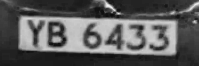

Processed video saved to output_video.avi
['YB 6433']


In [14]:
def main():
    penalized_texts = set()  # Initialize the list to store penalized texts
    # Open the video file
    video_path = r'/content/drive/MyDrive/traffic_video.mp4/traffic_video_modified.mp4'
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    # Get video properties for output video
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    output_path = 'output_video.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

    if not out.isOpened():
        print(f"Error: Could not open video writer with path {output_path}")
        return

    # Create detector object
    detector = LineDetector()

    # Loop through each frame in the video
    while True:
        # Read frame
        ret, frame = video.read()

        if not ret:
            break

        # Assuming rect is the rectangle where the traffic light is located
        rect = (1700, 40, 100, 250)

        # Detect traffic light color
        frame, color = detect_traffic_light_color(frame, rect)

        # Detect white line
        frame, mask_line = detector.detect_white_line(frame, color)

        # Process the frame if the light is red
        if color == "red":
            # Extract license plate
            frame, license_plate_images = extract_license_plate(frame, mask_line, license_plate_cascade) #license_plate_cascade"

            # Process each detected license plate
            for license_plate_image in license_plate_images:

                # Apply OCR to each license plate image
                text = apply_ocr_to_image(license_plate_image)
                # Add the detected license plate to the list if it matches the pattern and is not already in the list
                if text and re.match("^[A-Z]{2}\s[0-9]{3,4}$", text) and text not in penalized_texts:
                    penalized_texts.add(text)
                    print(f"\nFined license plate: {text}")
                    cv2_imshow(license_plate_image)
                    # Save the image of the license plate (optional)
                    filename = f"{text}.png"
                    cv2.imwrite(filename, license_plate_image)
        # Draw the penalized text onto the frame if there is any
        if penalized_texts:
            draw_penalized_text(frame, penalized_texts)

        # Write the processed frame to the output video
        out.write(frame)

    # Release the video capture and writer objects
    video.release()
    out.release()

    print(f"Processed video saved to {output_path}")
    print(list(penalized_texts))
# Call the main function to execute the code
main()
